In [2]:
!pip install pandas==0.25.0

  Using cached pytz-2019.3-py2.py3-none-any.whl (509 kB)


In [4]:
pip install matplotlib

  Using cached pyparsing-2.4.6-py2.py3-none-any.whl (67 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install scikit-learn==0.22.1

  Using cached joblib-0.14.1-py2.py3-none-any.whl (294 kB)


In [3]:
!pip install keras

In [2]:
!pip install h5py

In [15]:
#import PIL   # -> no need to explicitly import; only install in the env
# https://pypi.org/project/Pillow/2.2.1/
!pip install Pillow

In [ ]:
# https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

In [1]:
import os
import numpy as np
import pandas as pd
import gc  # garbage collector
from datetime import datetime

import matplotlib.pyplot as plt
# %matplotlib inline

import h5py

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report

In [2]:
import sys
import keras
import tensorflow as tf
#from keras.models import Sequential
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from keras import regularizers 
#from keras.layers.advanced_activations import LeakyReLU
#from keras.models import load_model
from keras.models import model_from_json
#from keras.callbacks import EarlyStopping
#from keras.callbacks import ModelCheckpoint

#from keras.layers import Dense,GlobalAveragePooling2D
#from keras.applications import MobileNet
from keras.preprocessing import image
#from keras.applications.mobilenet import preprocess_input
from keras.models import Model,load_model
from keras.optimizers import Adam
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input

Using TensorFlow backend.
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\envs\deep_learn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\envs\deep_learn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\envs\deep_learn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np

In [10]:
#keras.__version__

'2.3.1'

In [3]:
# set seeds
# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
# https://github.com/keras-team/keras/issues/2479#issuecomment-213987747

#import os
#os.environ[â€˜PYTHONHASHSEEDâ€™] = â€˜0â€™
#os.environ[â€œCUDA_VISIBLE_DEVICESâ€]=â€-1â€³
#os.environ[â€œTF_CUDNN_USE_AUTOTUNEâ€] =â€0â€³

from numpy.random import seed
seed(1)

import random
random.seed(1)

from tensorflow import set_random_seed   # this is for tensorflow v1
set_random_seed(1)
#tf.random.set_seed(1)

In [4]:
def summarize_diagnostics(history):
    # plot loss
    #plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.show()
    # plot accuracy
    #plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['acc'], color='blue', label='train')   # tensorflow 1
    plt.plot(history.history['val_acc'], color='orange', label='test')
    #plt.plot(history.history['accuracy'], color='blue', label='train')   # TF 2
    #plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #pyplot.savefig(filename + '_plot.png')
    #plt.close()

In [5]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
###########     define model    #################

# load model
incepRes_model = InceptionResNetV2(include_top=False, input_shape=(299, 299, 3)) 
incepRes_model.summary()
# set include_top=False to leave out the top layer for re-training to our use case
# we can specify input_shape as per original images used to train the network - then we have to preprocess our images
# otherwise, we can specify the shape of our images

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
________________________________________________________________________________

In [7]:
# mark loaded layers as not trainable
for layer in incepRes_model.layers:
    layer.trainable = False

incepRes_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
________________________________________________________________________________

In [8]:
# this code gave error when both GlobalAveragePooling2D & Flatten were enabled
# solution - use only 1
#'''
model = Sequential()
model.add(incepRes_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))

model.add(Dense(units=6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])   #RMSprop(lr=1e-5)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6291520   
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 60,628,646
Trainable params: 6,291,910
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
'''
#model = Sequential()
#model.add(incepRes_model)

# add new classifier layers
#flat1 = Flatten()(model.layers[-1].output)
#class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
#output = Dense(6, activation='softmax')(class1)

output = incepRes_model.layers[-1].output 
output = GlobalAveragePooling2D()(output)   # model.add(GlobalAveragePooling2D())
output = Dropout(0.2)(output)               # model.add(Dropout(0.2))
output = Flatten()(output)                  # model.add(Flatten())
#output = keras.layers.Flatten()(output)
output = Dense(64, activation='relu', kernel_initializer='he_uniform')(output)  # model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
output = Dropout(0.5)(output)               # model.add(Dropout(0.5))
output = Dense(units=6, activation='softmax')(output)   # model.add(Dense(units=6, activation='softmax'))

  
# define new model
model = Model(inputs = incepRes_model.inputs, outputs=output)

# compile model
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])   #RMSprop(lr=1e-5)
#opt = SGD(lr=0.001, momentum=0.9)
#model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()
'''

In [ ]:
# create data generators; for a self-built network
'''
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

## prepare iterators       ## CHANGE class_mode (binary or categorical), BASED ON NO. OF CLASSES
#train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
#                                             class_mode='binary', batch_size=64, target_size=(200, 200))
#test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
#                                           class_mode='binary', batch_size=64, target_size=(200, 200))    
train_it = train_datagen.flow_from_directory('./runData/train/', color_mode='grayscale',
                                             class_mode='categorical', batch_size=64, target_size=(200, 200))
test_it = test_datagen.flow_from_directory('./runData/test/', color_mode='grayscale',
                                           class_mode='categorical', batch_size=64, target_size=(200, 200))

In [9]:
#########    create data generator for transfer learning;    ######################

# preprocess_input subtracts the mean RGB channels of the imagenet dataset. This is because the model you are
# using has been trained on a different dataset
datagen = ImageDataGenerator(featurewise_center=True, preprocessing_function = preprocess_input)
# https://github.com/keras-team/keras/issues/9624
# https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras   
# https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
# google: using preprocess_input with datagen; preprocess_input keras vgg16
# is image scaling not required in transfer learning? what about other data augmentation?

# specify imagenet mean values for centering
#datagen.mean = [123.68, 116.779, 103.939]

# prepare iterator
train_it = datagen.flow_from_directory('./ml/train/', 
                                       #color_mode='grayscale',  # specify this if the network reads in grayscale images
                                       class_mode='categorical', 
                                       batch_size=64, target_size=(299, 299),
                                       shuffle=False)
test_it = datagen.flow_from_directory('./ml/test/', 
                                      #color_mode='grayscale',
                                      class_mode='categorical', 
                                      batch_size=64, target_size=(299, 299),
                                      shuffle=False)


Found 900 images belonging to 6 classes.
Found 900 images belonging to 6 classes.


In [10]:
#import PIL
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2020-03-25 17:10:07


In [11]:
#########    fit model    ###################
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)


Epoch 1/20


d:\install_loc\anaconda3\envs\tf2\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15/15 [==============================] - 57s 4s/step - loss: 23.9496 - accuracy: 0.0733 - val_loss: 3.0086 - val_accuracy: 0.1711
Epoch 2/20
15/15 [==============================] - 40s 3s/step - loss: 2.3677 - accuracy: 0.1800 - val_loss: 1.7917 - val_accuracy: 0.1667
Epoch 3/20
15/15 [==============================] - 40s 3s/step - loss: 1.7245 - accuracy: 0.1767 - val_loss: 1.7900 - val_accuracy: 0.1667
Epoch 4/20
15/15 [==============================] - 40s 3s/step - loss: 1.7063 - accuracy: 0.1822 - val_loss: 1.7885 - val_accuracy: 0.1456
Epoch 5/20
15/15 [==============================] - 40s 3s/step - loss: 1.7478 - accuracy: 0.1656 - val_loss: 1.7885 - val_accuracy: 0.1667
Epoch 6/20
15/15 [==============================] - 41s 3s/step - loss: 1.7501 - accuracy: 0.1022 - val_loss: 1.7882 - val_accuracy: 0.1667
Epoch 7/20
15/15 [==============================] - 41s 3s/step - loss: 1.6322 - accuracy: 0.2622 - val_loss: 1.1801 - val_accuracy: 0.2122
Epoch 8/20
15/15 [============

In [12]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2020-03-25 17:24:33


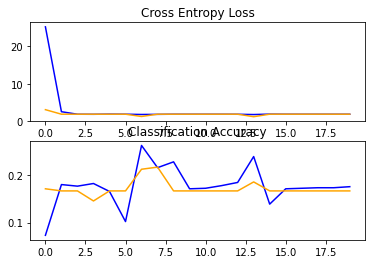

In [16]:
#########   evaluate model   ###############
summarize_diagnostics(history)

In [ ]:
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

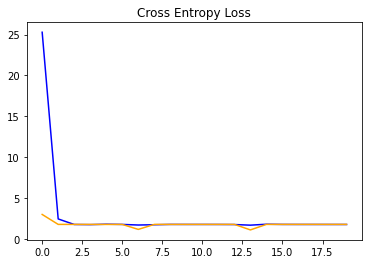

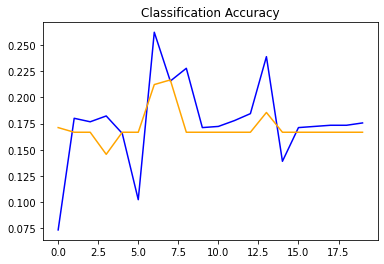

In [17]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

# plot accuracy

plt.title('Classification Accuracy')
    #plt.plot(history.history['acc'], color='blue', label='train')   # tensorflow 1
    #plt.plot(history.history['val_acc'], color='orange', label='test')
plt.plot(history.history['accuracy'], color='blue', label='train')   # TF 2
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()


## TRy Different way of writing the last layers of model

In [23]:
# this code gave error when both GlobalAveragePooling2D & Flatten were enabled
# solution - use only 1
#'''
# add new classifier layers
#flat1 = Flatten()(model.layers[-1].output)
#class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
#output = Dense(6, activation='softmax')(class1)

output = Flatten()(incepRes_model.layers[-1].output) 
#output = keras.layers.Flatten()(output)
output = Dense(64, activation='relu', kernel_initializer='he_uniform')(output)  # model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
#output = Dropout(0.5)(output)               # model.add(Dropout(0.5))
output = Dense(units=6, activation='softmax')(output)   # model.add(Dense(units=6, activation='softmax'))

# define new model
model1 = Model(inputs = incepRes_model.inputs, outputs=output)

# compile model
model1.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])   #RMSprop(lr=1e-5)
model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 149, 149, 32) 0           batch_normalization_204[0][0]    
____________________________________________________________________________________________

In [24]:
history = model1.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), epochs=3, verbose=1)


Epoch 1/3


d:\install_loc\anaconda3\envs\tf2\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15/15 [==============================] - 48s 3s/step - loss: 32.2145 - accuracy: 0.0622 - val_loss: 2.3073 - val_accuracy: 0.1756
Epoch 2/3
15/15 [==============================] - 40s 3s/step - loss: 2.7646 - accuracy: 0.1689 - val_loss: 1.7984 - val_accuracy: 0.1667
Epoch 3/3
15/15 [==============================] - 40s 3s/step - loss: 1.7926 - accuracy: 0.1667 - val_loss: 1.7955 - val_accuracy: 0.1667


## add model weights & try


In [20]:
# load model
incepRes_model = InceptionResNetV2(weights = "imagenet", include_top=False, input_shape=(299, 299, 3)) 
#incepRes_model.summary()

# mark the network as not trainable
for layer in incepRes_model.layers:
    layer.trainable = False

# add exra output layers
output = Flatten()(incepRes_model.layers[-1].output) 
#output = keras.layers.Flatten()(output)
output = Dense(64, activation='relu', kernel_initializer='he_uniform')(output)  # model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
#output = Dropout(0.5)(output)               # model.add(Dropout(0.5))
output = Dense(units=6, activation='softmax')(output)   # model.add(Dense(units=6, activation='softmax'))

# define new model
model1 = Model(inputs = incepRes_model.inputs, outputs=output)

# compile model
model1.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])   #RMSprop(lr=1e-5)
#model1.summary()

In [22]:
history = model1.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), epochs=4, verbose=1)


Epoch 1/4


d:\install_loc\anaconda3\envs\tf2\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15/15 [==============================] - 48s 3s/step - loss: 32.1425 - accuracy: 0.0944 - val_loss: 0.2911 - val_accuracy: 0.1667
Epoch 2/4
15/15 [==============================] - 40s 3s/step - loss: 2.4453 - accuracy: 0.0722 - val_loss: 1.7971 - val_accuracy: 0.1667
Epoch 3/4
15/15 [==============================] - 40s 3s/step - loss: 1.7055 - accuracy: 0.0833 - val_loss: 1.7960 - val_accuracy: 0.1911
Epoch 4/4
15/15 [==============================] - 40s 3s/step - loss: 1.6699 - accuracy: 0.1967 - val_loss: 1.7958 - val_accuracy: 0.1678


## try other network

In [6]:
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(include_top=False, input_shape=(224, 224, 3))   ## default: weights='imagenet'
vgg_model.summary()

W0325 23:04:31.056708 18120 deprecation_wrapper.py:119] From C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\envs\deep_learn\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0325 23:04:31.058701 18120 deprecation_wrapper.py:119] From C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\envs\deep_learn\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0325 23:04:31.064687 18120 deprecation_wrapper.py:119] From C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\envs\deep_learn\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0325 23:04:31.105577 18120 deprecation_wrapper.py:119] From C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\envs\deep_learn\lib\site-packages\keras\backend\tensorflow_backe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
# mark loaded layers as not trainable
for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
model = Sequential()
model.add(vgg_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))

model.add(Dense(units=6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])   #RMSprop(lr=1e-5)
model.summary()

W0325 23:04:47.641302 18120 deprecation_wrapper.py:119] From C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\envs\deep_learn\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 16,320,774
Trainable params: 1,606,086
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
from keras.applications.vgg16 import preprocess_input
datagen = ImageDataGenerator(featurewise_center=True, preprocessing_function = preprocess_input)


# prepare iterator
train_it = datagen.flow_from_directory('./ml/train/', 
                                       #color_mode='grayscale',  # specify this if the network reads in grayscale images
                                       class_mode='categorical', 
                                       batch_size=64, target_size=(224, 224),
                                       shuffle=False)
test_it = datagen.flow_from_directory('./ml/test/', 
                                      #color_mode='grayscale',
                                      class_mode='categorical', 
                                      batch_size=64, target_size=(224, 224),
                                      shuffle=False)


Found 900 images belonging to 6 classes.
Found 900 images belonging to 6 classes.


In [12]:
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), epochs=8, verbose=1)


Epoch 1/8
15/15 [==============================] - 641s 43s/step - loss: 13.9509 - acc: 0.0920 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 2/8
15/15 [==============================] - 575s 38s/step - loss: 13.5891 - acc: 0.1569 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 3/8
15/15 [==============================] - 595s 40s/step - loss: 13.5891 - acc: 0.1569 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 4/8
15/15 [==============================] - 540s 36s/step - loss: 13.5891 - acc: 0.1569 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 5/8
15/15 [==============================] - 586s 39s/step - loss: 13.5891 - acc: 0.1569 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 6/8
15/15 [==============================] - 599s 40s/step - loss: 13.5891 - acc: 0.1569 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 7/8
 8/15 [===============>..............] - ETA: 3:01 - loss: 11.3960 - acc: 0.2930

KeyboardInterrupt: 

## try separate data augmentation; change the data generators

## increase train dataset size

In [ ]:
## save model after training

#import h5py
model.save('final_model.h5')

In [ ]:
## load model

#from keras.models import load_model 
model = load_model('final_model.h5')

In [ ]:
### check performance on validation set, since no separate test set at the moment


In [ ]:
# we need to create generator with shuffle=false & also reset it, before using predict_generator
validation_generator2 = datagen.flow_from_directory('./ml/test/', #color_mode='grayscale',
                                      class_mode='categorical', batch_size=64, target_size=(224, 224), shuffle=False)


validation_generator2.reset() # resetting generator
y_pred = np.argmax(model.predict_generator(validation_generator2, steps= len(test_it)), axis=1)
y_pred

In [ ]:
# y_test  (actual labels)
validation_generator2.classes

In [ ]:
#### SEEING THE PREDICTIONS ####
# combine filename, y_test, y_pred into a df & flag mis-predictions

#dataf = pd.DataFrame([validation_generator2.filenames, validation_generator2.classes, y_pred]).T
dataf = pd.DataFrame(np.column_stack([validation_generator2.filenames, validation_generator2.classes, y_pred]),
                     columns=['name', 'true', 'pred'])
dataf.head(3)

In [ ]:
## getting the probabilities in each predicted class, for each test image
validation_generator2.reset() # resetting generator
probs = pd.DataFrame(model.predict_generator(validation_generator2, steps= len(test_it)))
probs.head(3)

In [ ]:
dataf = pd.concat([dataf,probs],axis=1)
dataf.head(3)

In [ ]:
## see misclassifications
dataf[dataf.true != dataf.pred]

In [ ]:
#########    performance metrics    ###############

In [ ]:
target_names = ['crazing','inclusion','patches','pittedSurface','rolled-in-scale','scratches']
print(classification_report(validation_generator2.classes, y_pred, target_names=target_names))

In [ ]:
accuracy_score(validation_generator2.classes, y_pred)

In [ ]:
print(confusion_matrix(validation_generator2.classes, y_pred))

In [ ]:
cnf_matrix = confusion_matrix(validation_generator2.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


In [ ]:
## predicting on new test data, without labels
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras